# Population-level dynamics


In [9]:
from nufeb_tools import utils,plot
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.signal import find_peaks
from pathlib import Path
from tqdm import tqdm

In [10]:

def get_biomass(folders):
    df = pd.DataFrame(columns=['Hours','cyano','ecw','IPTG','Sucrose','ss_time','suc_max','suc_end'])
   
    for folder in tqdm(sorted(folders)):
        x = utils.get_data(directory=str(folder))
        temp = x.biomass.reset_index()[['Hours','cyano','ecw']]
        temp.loc[:,'IPTG'] = x.IPTG
        temp.loc[:,'Sucrose']=x.avg_con['Sucrose']
        difference = np.diff(x.avg_con['Sucrose'].values,prepend=0)
        temp.loc[:,'ss_time'] = x.avg_con.index[np.argmin(difference)]
        temp.loc[:,'suc_max'] = x.avg_con['Sucrose'].max()
        temp.loc[:,'suc_end'] = x.avg_con['Sucrose'].iloc[-10:].mean()
        df=df.append(temp,ignore_index=True)
    df.loc[:,'pop_ratio'] = df.ecw/df.cyano
    return df

    


In [22]:
DIR = Path(r'E:\sucrose\runs')
folders = [path for path in DIR.iterdir() if path.is_dir()]
if Path(r'E:\sucrose.pkl').is_file():
    df = pd.read_pickle(r'E:\sucrose.pkl')
else:
    df = get_biomass(folders)
    df.to_pickle(r'E:\sucrose.pkl')

100%|██████████| 60/60 [21:04<00:00, 21.07s/it]


In [12]:
df.head()

,Hours,cyano,ecw,IPTG,Sucrose,ss_time,suc_max,suc_end,pop_ratio
0,0.000000,45564.85,9137.879,1.0,9.991236e-20,97.222222,30.440111,9.845532,0.200547
1,0.277778,46353.82,9135.868,1.0,NaN,97.222222,30.440111,9.845532,0.197090
2,0.555556,47156.46,9139.438,1.0,NaN,97.222222,30.440111,9.845532,0.193811
3,0.833333,47973.00,9148.549,1.0,NaN,97.222222,30.440111,9.845532,0.190702
4,1.111111,48803.67,9163.174,1.0,NaN,97.222222,30.440111,9.845532,0.187756


In [13]:
""" low = utils.get_data(directory= r'D:\runs\sucrose-sweep\Run_50_50_10_1_2021-09-21_167923')
med = utils.get_data(directory= r'D:\runs\sucrose-sweep\Run_50_50_50_1_2021-09-21_660658')
high = utils.get_data(directory= r'D:\runs\sucrose-sweep\Run_50_50_100_1_2021-09-21_943999') """

" low = utils.get_data(directory= r'D:\runs\\sucrose-sweep\\Run_50_50_10_1_2021-09-21_167923')\nmed = utils.get_data(directory= r'D:\runs\\sucrose-sweep\\Run_50_50_50_1_2021-09-21_660658')\nhigh = utils.get_data(directory= r'D:\runs\\sucrose-sweep\\Run_50_50_100_1_2021-09-21_943999') "

In [23]:
ratios = sorted(df.IPTG.unique())[::3]
ratios=ratios[1:]

In [15]:
""" runs = [r'D:\runs\Run_50_50_100_1_2021-08-04_879890',
        r'D:\runs\Run_50_50_100_1_2021-08-04_749751',
        r'D:\runs\Run_50_50_100_1_2021-08-04_738274',
        r'D:\runs\Run_50_50_100_1_2021-08-04_594614',
        r'D:\runs\Run_50_50_100_1_2021-08-04_584010',
        r'D:\runs\Run_50_50_100_1_2021-08-04_548827',
        r'D:\runs\Run_50_50_100_1_2021-08-04_462847',
        r'D:\runs\Run_50_50_100_1_2021-08-04_369407',
        r'D:\runs\Run_50_50_100_1_2021-08-04_262947',
        r'D:\runs\Run_50_50_100_1_2021-08-04_174205'
        ] """
def mu_sweep(DIR):
    folders = [path for path in DIR.iterdir() if path.is_dir()]
    mu_df = pd.DataFrame(columns=['IPTG','Biomass_ratio','mu_ecw','mu_ratio'])
    for folder in tqdm(sorted(folders)):
        
        try:
            x=utils.get_data(directory= folder)
            mu_df=mu_df.append(pd.DataFrame([[x.IPTG,x.biomass.iloc[-1,2]/x.biomass.iloc[-1,1],
            x.metadata['ecw']['GrowthRate'],
            x.metadata['ecw']['GrowthRate']/x.metadata['cyano']['GrowthRate']]],
            columns=['IPTG','Biomass_ratio','mu_ecw','mu_ratio']),
            ignore_index=True)
        except:
            print(f'Problem with data in {folder}')
    """     mus = list()
    mmu = list()
    for d in data:
        mus.append(d.metadata['ecw']['GrowthRate'])
        mmu.append(d.metadata['ecw']['GrowthRate']/d.metadata['cyano']['GrowthRate'])
    d2 = [x for _, x in sorted(zip(mus, data))]
    mu2 = sorted(mus)
    dmu = sorted(mmu)
    Ratio2 = [x.biomass.iloc[-1,2]/x.biomass.iloc[-1,1] for x in d2] """
    return mu_df
DIR = Path(r'E:\mu-sweep\runs')
if Path(r'E:\mu-sweep.pkl').is_file():
    mu_df = pd.read_pickle(r'E:\mu-sweep.pkl')
else:
    mu_df = mu_sweep(DIR)
    mu_df.to_pickle(r'E:\mu-sweep.pkl')


100%|██████████| 250/250 [1:12:41<00:00, 17.45s/it]


In [16]:
DIR = Path(r'E:\population-stability\runs')
def population_stability(DIR):

    folders = [path for path in DIR.iterdir() if path.is_dir()]
    x= list()
    y = list()
    sucs = list()
    for folder in tqdm(sorted(folders)):
        temp = utils.get_data(directory=str(folder))
        x.append(temp.biomass.reset_index()['Hours'])
        y.append(temp.biomass['ecw']/temp.biomass['cyano'])
        sucs.append(temp.IPTG)
    return x,y,sucs
if Path(r'E:\population-stability.pkl').is_file():
    [x,y,sucs] = pd.read_pickle(r'E:\population-stability.pkl')
else:
    x,y,sucs = population_stability(DIR)
    sucroseRatios=sorted(list(set(sucs)))
    [x,y,sucs].to_pickle(r'E:\population-stability.pkl')


100%|██████████| 210/210 [1:43:51<00:00, 29.67s/it]


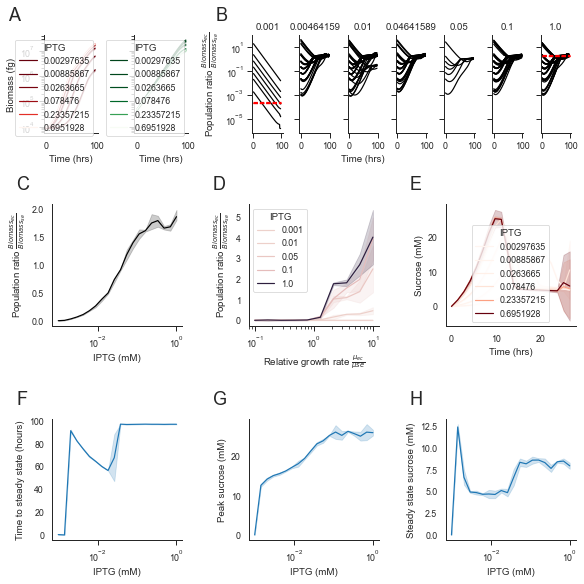

In [24]:
from matplotlib import transforms
fig = plt.figure(constrained_layout=True, figsize=(8,8))
widths = [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
heights = [1, .75, .75]
def label_panel(ax, letter, *,
                offset_left=0.5, offset_up=0.2, prefix='', postfix='', **font_kwds):
    kwds = dict(fontsize=18)
    kwds.update(font_kwds)
    # this mad looking bit of code says that we should put the code offset a certain distance in
    # inches (using the fig.dpi_scale_trans transformation) from the top left of the frame
    # (which is (0, 1) in ax.transAxes transformation space)
    fig = ax.figure
    trans = ax.transAxes + transforms.ScaledTranslation(-offset_left, offset_up, fig.dpi_scale_trans)
    ax.text(0, 1, prefix+letter+postfix, transform=trans, **kwds)

def label_panels(axes, letters=None, **kwds):
    if letters is None:
        letters = axes.keys()
    for letter in letters:
        ax = axes[letter]
        label_panel(ax, letter, **kwds)


gs0 = gridspec.GridSpec(3, 15, figure=fig,wspace=.7,hspace=.1, width_ratios=widths,
                          height_ratios=heights)
sns.set_context('paper')
sns.set_style('white')


# Biomass vs time
#ax1 = fig.add_subplot(gs0[0, :4])
#ax1_2 = fig.add_subplot(gs0[0, 5:8],sharey=ax1)
gs00 = gs0[0,:5].subgridspec(1,2)
with sns.axes_style("ticks"):
    ax1=gs00.subplots(sharey=True)
    sns.lineplot(x='Hours',y='ecw',hue='IPTG',data=df[df.IPTG.isin(ratios)],ci='sd',ax=ax1[0],palette='Reds_r')
    sns.lineplot(x='Hours',y='cyano',hue='IPTG',data=df[df.IPTG.isin(ratios)],ci='sd',ax=ax1[1],palette='Greens_r')
    ax1[0].set_yscale('log')
    ax1[0].set_xlabel('Time (hrs)')
    ax1[1].set_xlabel('Time (hrs)')
    ax1[0].set_ylabel('Biomass (fg)')
#ax1[1].set_ylabel('')
#ax1[1].set_yticklabels('')

# Population stability dynamics
gs01 = gs0[0,5:].subgridspec(1,len(sucroseRatios))
#ax3 = fig.add_subplot(gs0[0, 2])

#ax3_1 = fig.add_subplot(gs01[0])
#ax3_2 = fig.add_subplot(gs01[1], sharey=ax3_1)
#ax3_3 = fig.add_subplot(gs01[2], sharey=ax3_1)
#ax3_4 = fig.add_subplot(gs01[3], sharey=ax3_1)
with sns.axes_style("ticks"):
    ax3=gs01.subplots(sharey=True)
    for X,Y,S in zip(x,y,sucs):
        ax3[sucroseRatios.index(S)].plot(X,Y,c='k')
        ax3[sucroseRatios.index(S)].set_title(S)

    for ax in ax3.ravel():
        ax.set_yscale('log')
    ax3[0].set_ylabel(r'Population ratio $\frac{Biomass_{ec}}{Biomass_{se}}$')
    ax3[2].set_xlabel('Time (hrs)')
    for s in sucroseRatios:
        y_line = df.loc[(df.Hours==df.Hours.iloc[-1]) & (df.IPTG == s),'pop_ratio']
        if y_line.size > 0:
            ax3[sucroseRatios.index(s)].plot([0,100], [y_line,y_line], color='red', linestyle='--')



# Population ratio vs sucrose secretion level
with sns.axes_style("ticks"):
    ax4 = fig.add_subplot(gs0[1, :5])
    sns.lineplot(x='IPTG',y='pop_ratio',data=df.loc[df.Hours==df.Hours.iloc[-1]],ax=ax4,color='k')
    ax4.set_xlabel('IPTG (mM)')
    ax4.set_ylabel(r'Population ratio $\frac{Biomass_{ec}}{Biomass_{se}}$')
    ax4.set(xscale="log")
with sns.axes_style("ticks"):
# Population ratio vs relative growth rate
    ax5 = fig.add_subplot(gs0[1, 5:10])
    sns.lineplot(x='mu_ratio',y='Biomass_ratio',hue='IPTG',ci='sd',data=mu_df,ax=ax5)
    #ax5.plot(dmu,Ratio2,marker='o',color='k')
    ax5.set(xscale="log")
    ax5.set_xlabel(r'Relative growth rate $\frac{\mu_{ec}}{\mu{se}}$')
    ax5.set_ylabel(r'Population ratio $\frac{Biomass_{ec}}{Biomass_{se}}$')

# Sucrose over time
ax6 = fig.add_subplot(gs0[1, 10:])
sns.lineplot(x='Hours',y='Sucrose',hue='IPTG',data=df[df.IPTG.isin(ratios)],ci='sd',ax=ax6,palette='Reds')
""" for r in ratios:
    ax6.plot(r.Sucrose) """
""" plot.average_nutrients(low.avg_con,'Sucrose',color='#fee6ce',ax=ax6)
plot.average_nutrients(med.avg_con,'Sucrose',color='#fdae6b',ax=ax6)
plot.average_nutrients(high.avg_con,'Sucrose',color='#e6550d',ax=ax6) """
ax6.set_ylabel('Sucrose (mM)')
ax6.set_xlabel('Time (hrs)')

sns.set_context('paper')
sns.set_style('white')
# Time to steady state
with sns.axes_style("ticks"):
    ax7 = fig.add_subplot(gs0[2, :5])

    #ax7.bar(ratios,ss_time)#,color=colors
    sns.lineplot(x='IPTG',y='ss_time',ci='sd',data=df,ax=ax7)
    ax7.set_xlabel('IPTG (mM)')
    ax7.set_ylabel('Time to steady state (hours)')
    ax7.set(xscale="log")

# Peak sucrose
with sns.axes_style("ticks"):
    ax8= fig.add_subplot(gs0[2, 5:10])
    sns.lineplot(x='IPTG',y='suc_max',ci='sd',data=df,ax=ax8)
    #ax8.bar(ratios,suc_max)
    ax8.set_xlabel('IPTG (mM)')
    ax8.set_ylabel('Peak sucrose (mM)')
    ax8.set(xscale="log")
# Steady state sucrose
with sns.axes_style("ticks"):
    ax9 = fig.add_subplot(gs0[2, 10:])
    #ax9.bar(ratios,suc_end)
    sns.lineplot(x='IPTG',y='suc_end',ci='sd',data=df,ax=ax9)
    ax9.set_xlabel('IPTG (mM)')
    ax9.set_ylabel('Steady state sucrose (mM)')
    ax9.set(xscale="log")

label_panel(ax1[0],'A')
label_panel(ax3[0],'B')
label_panel(ax4,'C')
label_panel(ax5,'D')
label_panel(ax6,'E')
label_panel(ax7,'F')
label_panel(ax8,'G')
label_panel(ax9,'H')
#label_panels(ax1[0],ax3[0],ax4,ax5,ax6,ax7,ax8,ax9, letters='ABCDEFGH')
for ax in [ax4,ax5,ax7,ax8,ax9]:
    ax.tick_params(left=False)
for ax in [ax1[0],ax1[1]]:
    ax.tick_params(bottom=False)
sns.despine()
plt.show()
fig.savefig('../figures/Whole culture analysis V2.png',dpi=600)

In [18]:
sorted(df.IPTG.unique())

[0.001,
 0.00143845,
 0.00206914,
 0.00297635,
 0.00428133,
 0.00615848,
 0.00885867,
 0.01274275,
 0.01832981,
 0.0263665,
 0.0379269,
 0.05455595,
 0.078476,
 0.11288379,
 0.16237767,
 0.23357215,
 0.33598183,
 0.48329302,
 0.6951928,
 1.0]

In [19]:
np.logspace(-3,0,20)

array([0.001     , 0.00143845, 0.00206914, 0.00297635, 0.00428133,
       0.00615848, 0.00885867, 0.01274275, 0.01832981, 0.02636651,
       0.0379269 , 0.05455595, 0.078476  , 0.11288379, 0.16237767,
       0.23357215, 0.33598183, 0.48329302, 0.6951928 , 1.        ])

In [20]:
1e-3/11

9.090909090909092e-05